LOAD TRAIN DATASET

In [72]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
train_data_path = "/content/train_data.txt"
train_data = pd.read_csv("/content/train_data.txt",header =None,sep=":::",names =["ID","Title","Genres","Description"],engine ="python")

In [15]:
train_data.head()

,ID,Title,Genres,Description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


To check whether everything is filled

In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           54214 non-null  int64 
 1   Title        54214 non-null  object
 2   Genres       54214 non-null  object
 3   Description  54214 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [5]:
train_data.isnull().sum()

ID             0
Title          1
Genres         1
Description    1
dtype: int64

Filled the missing value

In [6]:
train_data["Title"].fillna("Unknown",inplace =True)
mode_genre =train_data['Genres'].mode()[0]
train_data["Genres"].fillna(mode_genre,inplace=True)
train_data["Description"].fillna("No description available",inplace =True)

In [7]:
train_data.isnull().sum()

ID             0
Title          0
Genres         0
Description    0
dtype: int64

LOAD TEST DATASET

In [20]:
test_path ="/content/test_data.txt"
test_data = pd.read_csv(test_path,sep =":::",names=["ID","Title","Description"],engine="python")

In [19]:
test_data.head()

,ID,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


In [17]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22918 entries, 0 to 22917
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           22918 non-null  int64 
 1   Title        22918 non-null  object
 2   Description  22918 non-null  object
dtypes: int64(1), object(2)
memory usage: 537.3+ KB


In [18]:
test_data.isnull().sum()

ID             0
Title          0
Description    0
dtype: int64

DATA PREPROCESSING

In [46]:
# Initialize the stemmer and stop words
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

# Define the clean_text function
def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keep words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  # Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces
    return text

# Apply the clean_text function to the 'Description' column in the training and test data
train_data['Text_cleaning'] = train_data['Description'].apply(clean_text)
test_data['Text_cleaning'] = test_data['Description'].apply(clean_text)

In [47]:
# Droping the redundant data
print("shape before drop nulls",train_data.shape)
train_data = train_data.drop_duplicates()
print("shape after drop nulls",train_data.shape)

shape before drop nulls (54214, 9)
shape after drop nulls (54214, 9)


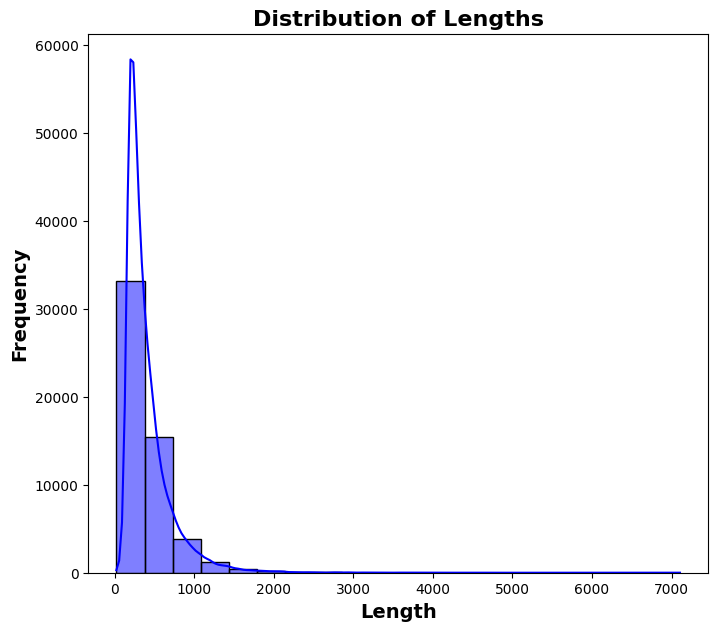

In [48]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

# Calculate the length of cleaned text
train_data['length_Text_cleaning'] = train_data['Text_cleaning'].apply(len)
# Visualize the distribution of text lengths
plt.figure(figsize=(8, 7))
sns.histplot(data=train_data, x='length_Text_cleaning', bins=20, kde=True, color='blue')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt.show()

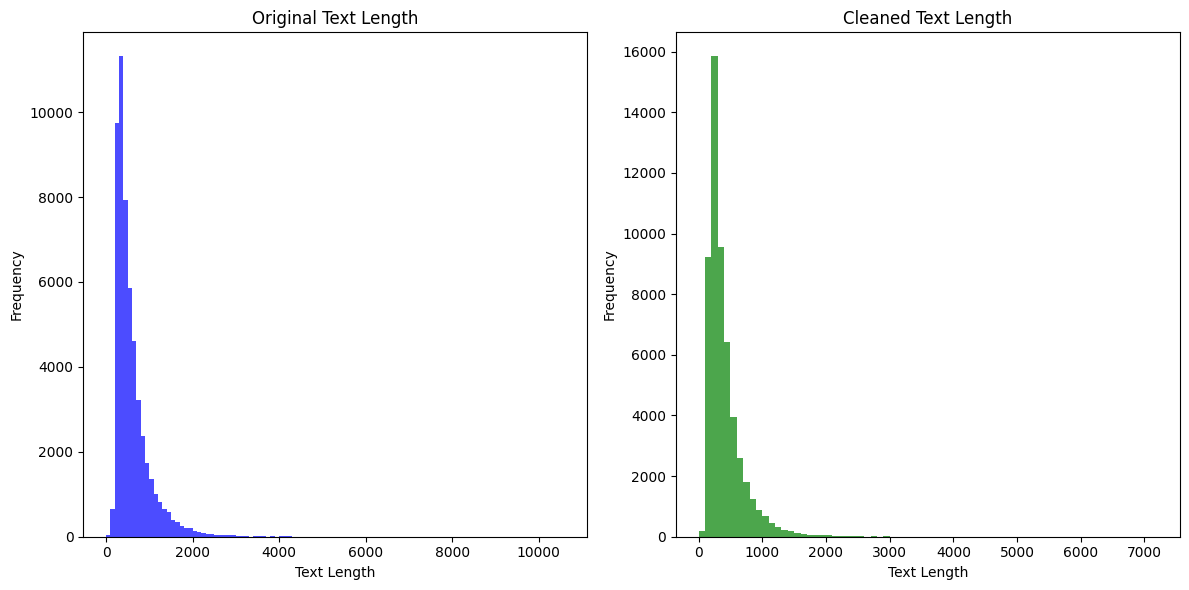

In [49]:
# Create histograms to visualize the distribution of text lengths before and after cleaning

# Set up the figure with two subplots
plt.figure(figsize=(12, 6))

# Subplot 1: Original text length distribution
plt.subplot(1, 2, 1)
original_lengths = train_data['Description'].apply(len)
plt.hist(original_lengths, bins=range(0, max(original_lengths) + 100, 100), color='blue', alpha=0.7)
plt.title('Original Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Subplot 2: Cleaned text length distribution
plt.subplot(1, 2, 2)
cleaned_lengths = train_data['Text_cleaning'].apply(len)
plt.hist(cleaned_lengths, bins=range(0, max(cleaned_lengths) + 100, 100), color='green', alpha=0.7)
plt.title('Cleaned Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

TEXT VECTORIZATION

In [52]:
#Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
#Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(train_data["Text_cleaning"])
#Transform the test data
X_test = tfidf_vectorizer.transform(test_data["Text_cleaning"])

SPLIT DATA AND TRAIN MODEL

In [54]:
#Splitting data into training and validation sets
X = X_train
y = train_data['Genres']
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.2,random_state =42)

NAIVE BAYES

In [60]:
import warnings
warnings.filterwarnings("ignore")
#Initializing and training Multinomial Navie Bayes Classifier
clf_NB = MultinomialNB()
clf_NB.fit(X_train,y_train)
#Making predictions
y_pred = clf_NB.predict(X_val)
#Evaluate performance of the model
accuracy = accuracy_score(y_val,y_pred)
print("Validdation Accuracy:",accuracy)
print(classification_report(y_val,y_pred))

Validdation Accuracy: 0.44526422576777647
               precision    recall  f1-score   support

      action        0.00      0.00      0.00       263
       adult        0.00      0.00      0.00       112
   adventure        0.00      0.00      0.00       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.61      0.04      0.07      1443
       crime        0.00      0.00      0.00       107
 documentary        0.54      0.90      0.67      2659
       drama        0.38      0.88      0.53      2697
      family        0.00      0.00      0.00       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.00      0.00      0.00        40
     history        0.00      0.00      0.00        45
      horror        0.00      0.00      0.00       431
       music        0.00      0.00      0.00       144
     musical        0.00      0.00      0.00        50
     mystery        0.

In [61]:
accuracy_NB = accuracy_score(y_val,y_pred)
accuracy_NB

0.44526422576777647

MAKING PREDICTION

In [66]:
#Using trained model to predict on the test data
X_test_predictions = clf_NB.predict(X_test)
test_data["Predicted_Genres_NB"] = X_test_predictions

In [75]:
test_data.head()

,ID,Title,Description,Text_cleaning,Predicted_Genres_NB
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",brane loves life car apartment job especially ...,drama
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belongin...,drama
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,one year life albin family shepherds north tra...,documentary
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",father died hasnt spoken brother years serious...,drama
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,known internationally martial arts superstar b...,drama
